# Part 1: Download data
- Download data with kaggle API
- Unzip data file
- Data Exploration

In [1]:
import os
from zipfile import ZipFile
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

In [2]:
# # Setting for kaggle api
# import os
# os.environ['KAGGLE_USERNAME'] = 'myname' # username
# os.environ['KAGGLE_KEY'] = 'mykey' # key

In [3]:
# !kaggle datasets download -d arunrk7/surface-crack-detection

In [4]:
# from zipfile import ZipFile

In [5]:
# # Create a ZipFile Object and load sample.zip in it
# with ZipFile('surface-crack-detection.zip', 'r') as zipObj:
#    # Extract all the contents of zip file in current directory
#    zipObj.extractall()

In [6]:
neg_img_dir = './Negative'
pos_img_dir = './Positive'
neg_img_fnames = os.listdir(neg_img_dir)
pos_img_fnames = os.listdir(pos_img_dir)

print("Total negative images:", len(os.listdir(neg_img_dir)))
print("Total positive images:", len(os.listdir(pos_img_dir)))

Total negative images: 20000
Total positive images: 20000


In [7]:
nrows , ncols = 4,4
pic_index = 0 
random.shuffle(neg_img_fnames)
random.shuffle(pos_img_fnames)

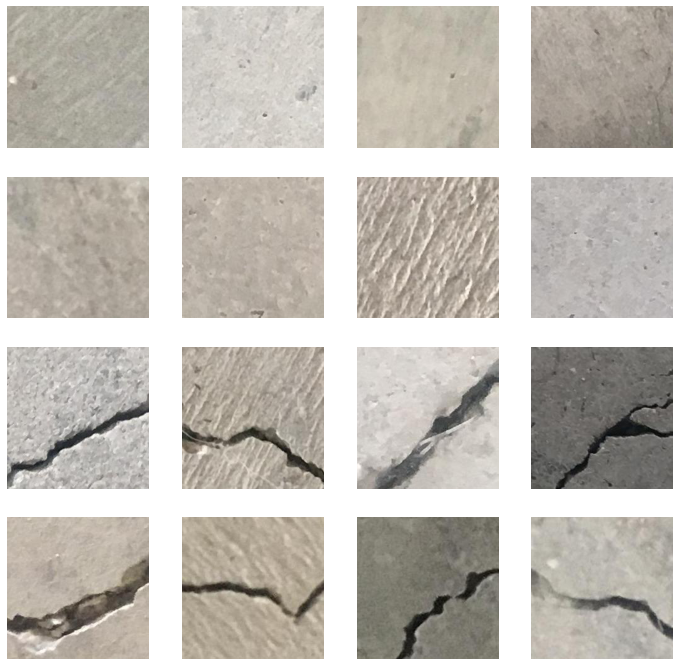

In [8]:
fig = plt.gcf()
fig.set_size_inches(ncols * 3, nrows *3)
pic_index+=8

next_neg_pix = [os.path.join(neg_img_dir,f) for f in neg_img_fnames[pic_index-8:pic_index]]
next_pos_pix = [os.path.join(pos_img_dir,f) for f in pos_img_fnames[pic_index-8:pic_index]]

for i,img_path in enumerate(next_neg_pix +  next_pos_pix):
    sp = plt.subplot(ncols,nrows,i+1)
    sp.axis("Off")
    img = mpimg.imread(img_path)
    plt.imshow(img)
plt.show()

# Part 2: Preprocessing Data

In [9]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from glob import glob

In [10]:
img_list = glob('Negative/*.jpg')
img_list_p = glob('Positive/*.jpg')

train_img_list, val_img_list = train_test_split(img_list, test_size=0.1, random_state=42)


def img_to_np(fpaths, resize=True):  
    img_array = []
    for fname in fpaths:
      try:
        img = Image.open(fname).convert('RGB')
        if(resize): img = img.resize((64, 64))
        img_array.append(np.asarray(img))
      except:
        continue
    images = np.array(img_array)
    return images

x_train = img_to_np(train_img_list[:1000])
x_train = x_train.astype(np.float32) / 255.

x_val = img_to_np(val_img_list[:200])
x_val = x_val.astype(np.float32) / 255.

x_val_p = img_to_np(img_list_p[:200])
x_val_p = x_val_p.astype(np.float32) / 255.


print('X Train for neg shape:     ',x_train.shape)
print('X Validation for neg shape:',x_val.shape)
print('X Validation for pos shape:',x_val.shape)

X Train for neg shape:      (1000, 64, 64, 3)
X Validation for neg shape: (200, 64, 64, 3)
X Validation for pos shape: (200, 64, 64, 3)


# Part 3: Build ConvAE model

In [11]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, add
from tensorflow.keras.layers import Layer, Dense, Dropout, Activation, Flatten, Reshape
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D

In [12]:
x = Input(shape=(64, 64, 3)) 

# Encoder
conv1_1 = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
pool1 = MaxPooling2D((2, 2), padding='same')(conv1_1)
conv1_2 = Conv2D(8, (3, 3), activation='relu', padding='same')(pool1)
pool2 = MaxPooling2D((2, 2), padding='same')(conv1_2)
conv1_3 = Conv2D(8, (3, 3), activation='relu', padding='same')(pool2)
h = MaxPooling2D((2, 2), padding='same')(conv1_3)


# Decoder
conv2_1 = Conv2D(8, (3, 3), activation='relu', padding='same')(h)
up1 = UpSampling2D((2, 2))(conv2_1)
conv2_2 = Conv2D(8, (3, 3), activation='relu', padding='same')(up1)
up2 = UpSampling2D((2, 2))(conv2_2)
conv2_3 = Conv2D(16, (3, 3), activation='relu', padding='same')(up2)
up3 = UpSampling2D((2, 2))(conv2_3)
r = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(up3)

autoencoder = Model(inputs=x, outputs=r)
autoencoder.compile(optimizer='adam', loss='mse')

In [13]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 8)         584       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 8)           0     

# Part 4: Train Model

In [14]:
epochs = 20
batch_size = 128

history = autoencoder.fit(x_train, x_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_val, x_val))

Epoch 1/20
8/8 [==============================] - 4s 466ms/step - loss: 0.0461 - val_loss: 0.0192
Epoch 2/20
8/8 [==============================] - 3s 319ms/step - loss: 0.0157 - val_loss: 0.0097
Epoch 3/20
8/8 [==============================] - 3s 323ms/step - loss: 0.0097 - val_loss: 0.0090
Epoch 4/20
8/8 [==============================] - 3s 323ms/step - loss: 0.0090 - val_loss: 0.0079
Epoch 5/20
8/8 [==============================] - 3s 324ms/step - loss: 0.0079 - val_loss: 0.0074
Epoch 6/20
8/8 [==============================] - 3s 325ms/step - loss: 0.0072 - val_loss: 0.0070
Epoch 7/20
8/8 [==============================] - 3s 320ms/step - loss: 0.0069 - val_loss: 0.0066
Epoch 8/20
8/8 [==============================] - 3s 321ms/step - loss: 0.0066 - val_loss: 0.0063
Epoch 9/20
8/8 [==============================] - 3s 323ms/step - loss: 0.0064 - val_loss: 0.0062
Epoch 10/20
8/8 [==============================] - 3s 319ms/step - loss: 0.0063 - val_loss: 0.0060
Epoch 11/20
8/8 [==

dict_keys(['loss', 'val_loss'])


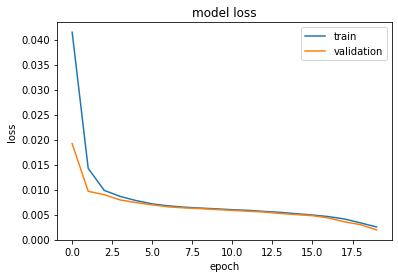

In [15]:
print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

# Part 4: Evaluate Model

In [16]:
decoded_imgs = autoencoder.predict(x_val)
img_shape = (64,64,3)

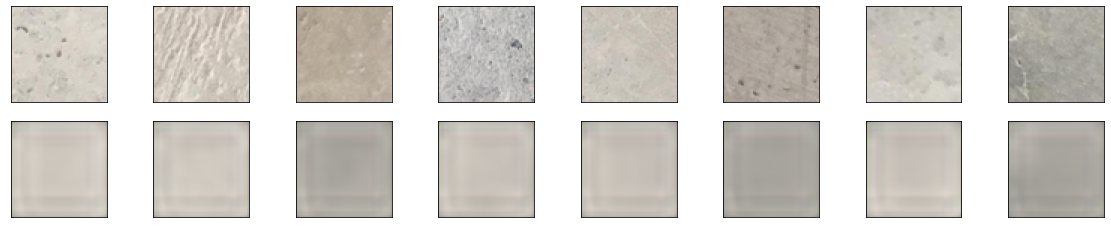

In [17]:
n = 8
plt.figure(figsize=(20, 6))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i+1)
    plt.imshow(x_val[i].reshape(*img_shape ))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    
    # display reconstruction
    ax = plt.subplot(3, n, i+n+1)
    plt.imshow(decoded_imgs[i].reshape(*img_shape))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

In [18]:
decoded_imgs_p = autoencoder.predict(x_val_p)

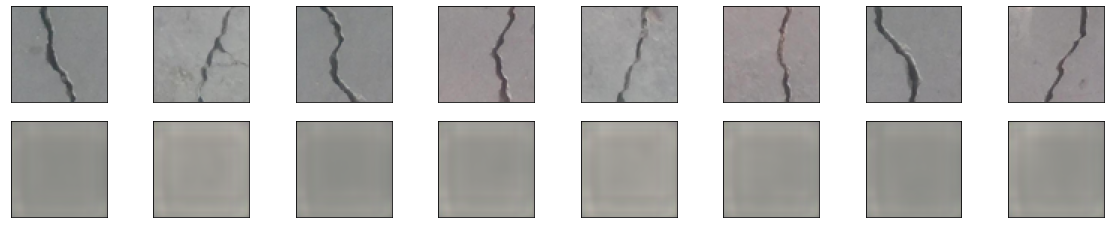

In [19]:
n = 8
plt.figure(figsize=(20, 6))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i+1)
    plt.imshow(x_val_p[i].reshape(*img_shape ))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    
    # display reconstruction
    ax = plt.subplot(3, n, i+n+1)
    plt.imshow(decoded_imgs_p[i].reshape(*img_shape))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

In [20]:
def get_mse_scores(model,x):
    sc = []
    for i in x :
        a = np.expand_dims(i,0)
        s = model.evaluate(a,a)
        sc.append(s)
    return sc

In [21]:
mse_pos = get_mse_scores(autoencoder,x_val_p)
mse_neg = get_mse_scores(autoencoder,x_val)

1/1 [==============================] - 0s 12ms/step - loss: 0.0205


1/1 [==============================] - 0s 12ms/step - loss: 9.5962e-04


1/1 [==============================] - 0s 11ms/step - loss: 0.0020


1/1 [==============================] - 0s 12ms/step - loss: 0.0017


In [62]:
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support

AUC reaches:  0.97555


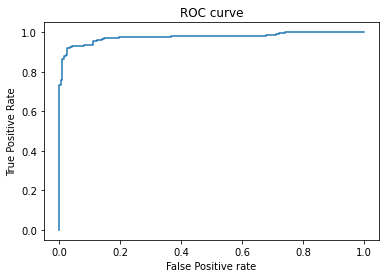

In [43]:
y_true = np.array( [1] * 200 + [0] *200 )
y_prob = np.array(mse_pos + mse_neg)
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_prob)

# AUC
print("AUC reaches: ",metrics.auc(fpr, tpr))

# Print ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive rate')
plt.title('ROC curve')
plt.show() 

In [26]:
metrics.auc(fpr, tpr)

0.97555

# Part 5: Find Optimal Threshold

In [59]:
threshold_evals = []
for threshold in thresholds:
    y_pred = (y_prob > threshold)
    precision,recall,F1,_ = precision_recall_fscore_support(y_true,y_pred,average = 'binary')
    threshold_evals.append([threshold,precision,recall,F1])

In [63]:
df_threshold = pd.DataFrame(threshold_evals, columns = ['threshold','precision','recall','F1scroe'])

In [67]:
df_threshold.sort_values('recall',ascending=False)

,threshold,precision,recall,F1scroe
41,0.000538,0.501253,1.000,0.667780
40,0.001263,0.573487,0.995,0.727605
39,0.001264,0.575145,0.995,0.728938
38,0.001306,0.578947,0.990,0.730627
37,0.001316,0.580645,0.990,0.731978
36,0.001345,0.581121,0.985,0.730983
35,0.001351,0.582840,0.985,0.732342
33,0.001386,0.592145,0.980,0.738230
31,0.001622,0.657718,0.980,0.787149
32,0.001620,0.655518,0.980,0.785571
